<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARIMA%20SONNNNNNNNNNNNNNNNNNNNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [234]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

stock = "ISMEN.IS"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download(stock, start="2006-01-01", end="2023-09-13")

df_close = stock_data['Close']
df_log = np.log(df_close)
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

best_order = model_autoARIMA.order
print("Best ARIMA Order:", best_order)

[*********************100%%**********************]  1 of 1 completed
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19004.583, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19003.094, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19003.090, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18999.587, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18964.245, Time=2.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.663 seconds
Best ARIMA Order: (0, 1, 0)


In [235]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

start="2023-09-01"
end="2023-09-14"

stock_data = yf.download(stock, start=start, end=end, progress=False)
model = ARIMA(np.log(stock_data["Close"]), order=best_order)
fitted = model.fit()

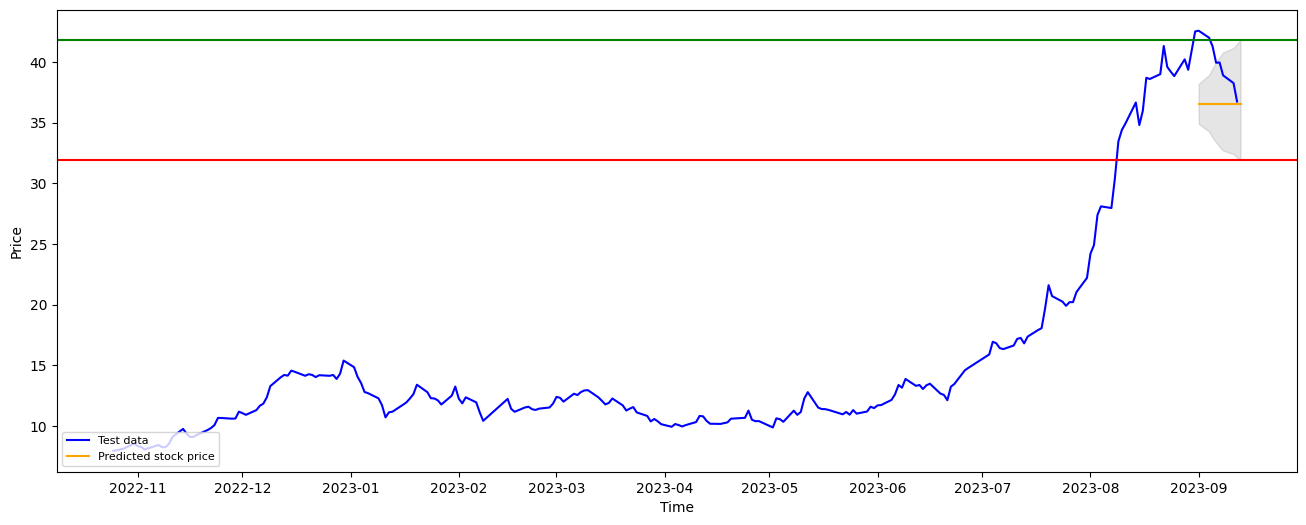

In [233]:
forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(16,6), dpi=100)
# plt.plot(np.exp(train_data[3500:]), label='Training data', color="black")
plt.plot(np.exp(test_data[200:]), color='blue', label='Test data')


# plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
# plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
#                  color='k', alpha=.10)

# plt.plot(stock_data["Close"], color='red', label='Excluded stock data')

plt.plot(stock_data.index, np.exp(fc), color='orange', label='Predicted stock price')  # Convert back to original scale
plt.fill_between(stock_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

In [ ]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Assuming you already have the forecast_results, fc, conf, fc_series, lower_series, and upper_series

# Extend the time horizon by 30 days
extended_steps = 50
forecast_extended = fitted.get_forecast(steps=len(test_data) + extended_steps, alpha=0.05)

# Extract the extended forecast and confidence intervals
fc_extended = forecast_extended.predicted_mean
conf_extended = forecast_extended.conf_int()

# Create Series for the extended forecast and confidence intervals
fc_series_extended = pd.Series(fc_extended, index=fc_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
lower_series_extended = pd.Series(conf_extended.iloc[:, 0], index=lower_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
upper_series_extended = pd.Series(conf_extended.iloc[:, 1], index=upper_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))

# Plot the extended forecast
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')
plt.plot(fc_series_extended.index, np.exp(fc_extended), color='purple', linestyle='--', label='Extended Predicted Stock Price')  # Convert back to original scale

# Fill the area between the confidence intervals
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]), color='k', alpha=.10)
plt.fill_between(fc_series_extended.index, np.exp(conf_extended.iloc[:, 0]), np.exp(conf_extended.iloc[:, 1]), color='purple', alpha=.10)

# Add horizontal lines for the maximum and minimum bounds of the confidence intervals
plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
